In [1]:
# requirements: numpy, sympy, scipy, matplotlib, symbtools, ipydex


import symbtools as st
import sympy as sp
import numpy as np
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt

%load_ext ipydex.displaytools

In [2]:
# plotting configuration
%matplotlib inline
plt.rcParams['text.usetex'] = True
plt.rcParams["axes.labelsize"] = "x-large"

In [3]:
N = 3

xx = st.symb_vector(f"x1:{N+1}") ##:
s = sp.Symbol("s")
z = sp.Symbol("z")

xx := Matrix([
[x1],
[x2],
[x3]])

---

In [4]:
def poly(roots, var=None):
    """
    create polynomial expression for given sequence of roots
    """
    if var is None:
        var = sp.Symbol("lambda")
    return sp.expand(sp.Mul(*[var-root for root in roots]))


# initial naive attempt (does not work)

## clcp1 = sp.expand((s+1)**N) ##:
## clcp2 = sp.expand((s-1)**N) ##:


# test of poly function:
clcp1 = poly([-1 + 1j, -1 - 1j, -3]) ##:
clcp2 = poly([1 + 1j, 1 - 1j, 3]) ##:

clcp1 := lambda**3 + 5.0*lambda**2 + 8.0*lambda + 6.0

---

clcp2 := lambda**3 - 5.0*lambda**2 + 8.0*lambda - 6.0

---

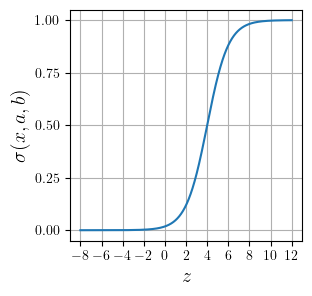

In [5]:
def get_sigma_expr(z, a=1, b=0):
    return 1/(1+sp.exp(-a*(z-b)))

zz = np.linspace(-8, 12, 1000)
sigma_func = st.expr_to_func(z, get_sigma_expr(z, b=4))


fig = plt.figure(figsize=(3, 3))

plt.xticks(range(-8, 13, 2))
plt.yticks(np.arange(0, 1.5, 0.25))
plt.xlabel("$z$")
plt.ylabel("$\\sigma(x, a, b)$")
plt.grid()

plt.plot(zz, sigma_func(zz))
plt.savefig("sigma_func.pdf")

In [6]:
# Construct System in Controller Canonical Form: xdot = Ax + bu
A = sp.zeros(N, N)
A[:-1, 1:] = sp.eye(N-1)

A ##:

b = sp.eye(N)[:, -1] ##:


(A) := Matrix([
[0, 1, 0],
[0, 0, 1],
[0, 0, 0]])

---

b := Matrix([
[0],
[0],
[1]])

---

In [7]:
metric_expr = (xx.T*xx)[0] ##:

metric_expr := x1**2 + x2**2 + x3**2

---

In [8]:
scale_expr = get_sigma_expr(metric_expr, a=1, b=20)

# this was found by some manual trial and error:

stable_eigvals = np.r_[-.3 + 1j, -.3 - 1j, -.1]*.5 ##:
unstable_eigvals = np.r_[1 + 1j, 1 - 1j, 2] ##:

clcp1 = poly(stable_eigvals) ##:

clcp2 = poly(unstable_eigvals) ##:

coeff_list1 = st.clean_numbers(st.coeffs(clcp1))
coeff_list2 = st.clean_numbers(st.coeffs(clcp2))

fb_law1 = -1*sp.Matrix(coeff_list1[1:][::-1]).T * xx # #: # stable
fb_law2 = -1*sp.Matrix(coeff_list2[1:][::-1]).T * xx # #: # unstable


fback = (fb_law1*(scale_expr) + fb_law2*(1-scale_expr))


rhs = A*xx + b*fback

rhs_last_row = st.clean_numbers(rhs[-1, 0]) ##:
rhs_func = st.expr_to_func(xx, rhs)
fback_func = st.expr_to_func(xx, fback)
scale_func = st.expr_to_func(xx, scale_expr)


stable_eigvals := array([-0.15+0.5j, -0.15-0.5j, -0.05+0.j ])

---

unstable_eigvals := array([1.+1.j, 1.-1.j, 2.+0.j])

---

clcp1 := lambda**3 + 0.35*lambda**2 + 0.2875*lambda + 0.013625

---

clcp2 := lambda**3 - 4.0*lambda**2 + 6.0*lambda - 4.0

---

rhs_last_row := (1 - 1/(exp(-x1**2 - x2**2 - x3**2 + 20) + 1))*(4*x1 - 6*x2 + 4*x3) + (-109*x1/8000 - 23*x2/80 - 7*x3/20)/(exp(-x1**2 - x2**2 - x3**2 + 20) + 1)

---

## Simulation

In [9]:
M = 10000

tt = np.linspace(0, 300, M)

M2 = int(M/2)*0

def rhs_func2(t, xx):
    return rhs_func(*xx)

xx0 = np.array([6] + [0]*(N-1))
sol1 = solve_ivp(rhs_func2, (tt[0], tt[-1]), xx0, t_eval=tt)


# 2nd simulation of nearby trajectory
eps = 1e-5
sol2 = solve_ivp(rhs_func2, (tt[0], tt[-1]), xx0*(1+eps), t_eval=tt)

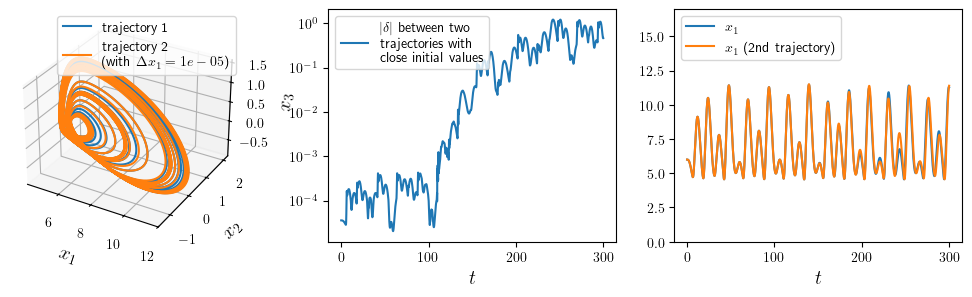

In [10]:
plt.rcParams["axes.labelsize"] = "x-large"

plt.rcParams['figure.subplot.bottom'] = .1
plt.rcParams['figure.subplot.left'] = 0.01
plt.rcParams['figure.subplot.top'] = .995
plt.rcParams['figure.subplot.right'] = .99


fig = plt.figure(figsize=(10, 2.6))

ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.plot(sol1.y[0, M2:], sol1.y[1, M2:], sol1.y[2, M2:], label="trajectory 1")
ax.plot(sol2.y[0, M2:], sol2.y[1, M2:], sol2.y[2, M2:], label=f"trajectory 2\n(with $\\Delta x_1={eps}$)")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
ax.legend()

ax2 = fig.add_subplot(1, 3, 2)

diff = sol1.y-sol2.y

diff_sum = np.sum(diff**2, axis=0)**.5
ax2.plot(tt, diff_sum[:], label="$|\\delta|$ between two\ntrajectories with\nclose initial values")
ax2.set_yscale('symlog', linthresh=0.0001)
ax2.legend(loc="upper left")
ax2.set_xlabel("$t$")

ax3 = fig.add_subplot(1, 3, 3)

ax3.plot(tt[M2:], sol1.y[0, M2:], label="$x_1$")
ax3.plot(tt[M2:], sol2.y[0, M2:], label="$x_1$ (2nd trajectory)")
# ax3.plot(tt[M2:], sol1.y[1, M2:], label="$x_2$")
# ax3.plot(tt[M2:], sol1.y[2, M2:], label="$x_3$")
ax3.set_xlabel("$t$")
ax3.set_ylim(0, 17)



# ax3.plot(tt[M2:], fback_func(sol1.y[0, M2:], sol1.y[1, M2:], sol1.y[2, M2:]), label="feedback")
# ax3.plot(tt[M2:], sw_func(sol1.y[0, M2:], sol1.y[1, M2:], sol1.y[2, M2:]), label="sw_func")
ax3.legend(loc="upper left")
plt.subplots_adjust(wspace=0.2)


plt.savefig("strange-attractor.pdf")
plt.show()
